### Basic Grammar Checker from GingerIt

In [1]:
from gingerit.gingerit import GingerIt

In [2]:
text = 'The smelt of fliwers bring back memories.'

parser = GingerIt()
text_ = parser.parse(text)
text_['result']
parser.parse('I is glad to has good frends like you')

{'text': 'I is glad to has good frends like you',
 'result': 'I am glad to have good friends like you',
 'corrections': [{'start': 22,
   'text': 'frends',
   'correct': 'friends',
   'definition': 'a person you know well and regard with affection and trust'},
  {'start': 13, 'text': 'has', 'correct': 'have', 'definition': None},
  {'start': 2, 'text': 'is', 'correct': 'am', 'definition': None}]}

### Formality Classifier (Work in Progress)

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
nltk.download('stopwords')
nltk.download('wordnet')

# Reading in the csv as a dataframe
df = pd.read_csv('formal_informal_data.csv', encoding = "utf-8")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Steve\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
df.head()

,text,label
0,please don't give room for the devil.,0
1,"in a public place, tell her to get on her knee.",1
2,MOVE ON...many more options out there,1
3,They like American and European guys.,1
4,Umm i want to know i f ill have a bf this year...,1


In [5]:
df['text'] = df['text'].astype(str)

In [6]:
df['text']

0                    please don't give room for the devil.
1          in a public place, tell her to get on her knee.
2                    MOVE ON...many more options out there
3                    They like American and European guys.
4        Umm i want to know i f ill have a bf this year...
                               ...                        
49995    I know it sounds like a formula but girls are ...
49996           Women like bodies just as much as guys do.
49997             If that were me I would get mad as hell.
49998             We're not best friends, but anyway......
49999             yahoo personals is good, so is match.com
Name: text, Length: 50000, dtype: object

In [7]:
# Basic Text Cleaning
stop_words = stopwords.words('english')

# Removing apostrophes so contractions are considered a single token
df['clean_text'] = df['text'].apply(lambda x: re.sub("'", '', x))

# Remove punctuation and stop words and lowercase the text
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(re.sub(
    r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words))

In [8]:
lemmatizer = WordNetLemmatizer()
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(w) for w in x.split()))

In [9]:
# Split the data into a training and test set for H2O
train, test = train_test_split(df, test_size=0.15, random_state = 123)

In [10]:
# Vectorize each tweet using Tf-Idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a Tf-Idf vectorizer that uses words as features if they occur at
# least 3 times in the corpus and include bigrams
vectorizer = TfidfVectorizer(ngram_range = (1, 2)) 

# Fit the vectorizer to the cleaned training data
vectorizer.fit(train['clean_text'])

# Vectorize the text for both the training and testing set
tfidf_train = vectorizer.transform(train['clean_text'])
tfidf_test  = vectorizer.transform(test['clean_text'])

In [11]:
# Train/use a Random Forest forest model for classification
from sklearn.ensemble import RandomForestClassifier

# Instantiate a model with 500 trees
rfc = RandomForestClassifier(n_estimators=1, random_state = 123)

# Fit to the training data
rfc = rfc.fit(tfidf_train, train['label'])

# Test the accuracy of the model on the testing data
test_set_acc = rfc.score(tfidf_test, test['label'])

print(f'Random Forest labeling accuracy: {str(round(test_set_acc*100,2))}')

Random Forest labeling accuracy: 36.19


Text(0.5, 1.0, 'Relative Importance of Features')

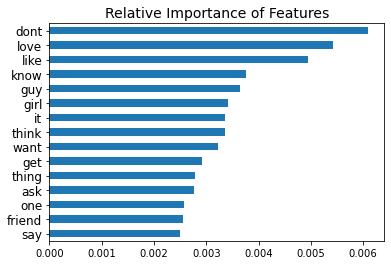

In [12]:
import matplotlib.pyplot as plt

# Convert vectors back to words to plot variable importance
ft_importances = pd.Series(rfc.feature_importances_, index=vectorizer.get_feature_names())
ft_importances.nlargest(15).sort_values().plot(kind='barh')
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.title("Relative Importance of Features",fontsize = 14)

In [16]:
import anvil.server

anvil.server.connect("Y3HQ5TAQWVK6YEZGBOWO7SZK-YL7IQYP2GJT7MXNS")

@anvil.server.callable
def grammar_checker(text):
    if parser.parse(text)['corrections']:
        return parser.parse(text)['result']
    else:
        return 'No corrections needed.'
    
@anvil.server.callable    
def formality_checker(text):
    text = re.sub("'", '', text)
    text = ' '.join(re.sub(
    r'[^a-zA-Z]',' ',w).lower() for w in text.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words)
    text = ' '.join(lemmatizer.lemmatize(w) for w in text.split())
    vector = vectorizer.transform([text])
    ynew = rfc.predict(vector)
    if ynew[0] == 1:
        return 'Informal'
    else:
        return 'Formal'
anvil.server.wait_forever()

KeyboardInterrupt: 